In [1]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

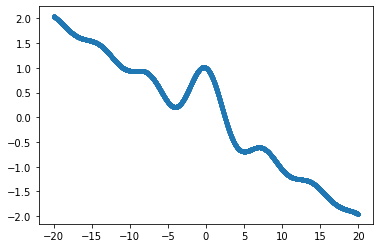

In [3]:
df = pd.DataFrame(np.linspace(-20, 20, 8192), columns=['x'])
df['y'] = np.sin(df['x']) / df['x'] - (df['x'] / 10)
plt.plot(df['x'], df['y'], '.')

In [4]:
n_epochs = 100  
lr = 0.0005    

b1 = 0.05        
b2 = 0.999     

latent_dim = 1000    

sample_interval = 100 


In [5]:
batch_size = 32
real_data = torch.utils.data.DataLoader(
    df.to_numpy(),
    batch_size=batch_size,
    shuffle=True)

real_data

In [6]:

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает 
            
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), 
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
        )
        
    def forward(self, z):
        num = self.model(z)
        return num

In [7]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)
        
        nn.init.uniform_(self.weights, -0.5, 0.5) 
        nn.init.uniform_(self.bias, -0.5, 0.5)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, pred):
        validity = self.model(pred)
        return validity

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [9]:
d_loss_history = []
g_loss_history = []

[Epoch 99/100] [Batch 156/256]|[D loss: 0.8451364040374756] [G loss: 0.9113823175430298]


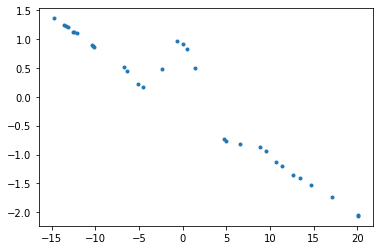

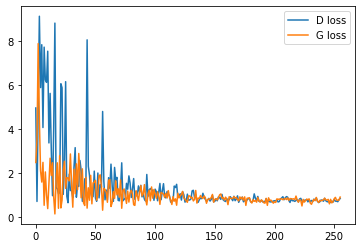

In [10]:
import matplotlib.patches as mpatches

for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
      current_bs = len(data)
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
          
      valid = torch.FloatTensor(current_bs, 1).fill_(1.0).to(device)
      # ложные значения
      fake = torch.FloatTensor(current_bs, 1).fill_(0.0).to(device)

      # генерация шума (нормальное распределение тут не подойдёт)
      z = Variable(torch.FloatTensor(np.random.uniform(-50, 50, (current_bs, latent_dim)))).to(device)
      
      # реальные значения перекладываем на устройство
      real_ex = Variable(data.type(torch.FloatTensor)).to(device)

      # Генерируем данные Генератором на основе шума
      gen_data = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
      # Получаем предсказания дискриминатора на основе реальных данных
      real_pred = discriminator(real_ex)
      
      # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
      d_real_loss = adversarial_loss(real_pred, valid)
      
      # Подаем сгенерированые данные на Дискриминатор 
      fake_pred = discriminator(gen_data)
      
      # расчитываем ошибку предсказанного с фейковыми лейблами
      d_fake_loss = adversarial_loss(fake_pred, fake)
      
      # И усредняем два лосса в один
      d_loss = (d_real_loss + d_fake_loss) / 2

      optimizer_D.zero_grad()
      d_loss.backward()
      optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
      z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
      
      # Генерируем данные Генератором на основе шума
      gen_points = generator(z)

      # Подаем сгенерированые данные на Дискриминатор 
      fake_pred = discriminator(gen_points)
  
      # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
      g_loss = adversarial_loss(fake_pred, valid)
      
      # Делаем шаг обучения нашего Генератора
      optimizer_G.zero_grad()
      g_loss.backward()
      optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
      batches_done = epoch * len(real_data) + i
  
      if batches_done % sample_interval == 0:
          with torch.no_grad():
              plt.clf()

              display.clear_output(wait=False)

              generated_samples = gen_points.detach().cpu()
              plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

              print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
              print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


              # display.display(plt.gcf())
              plt.show()
              d_loss = d_loss.cpu().detach()
              g_loss = g_loss.cpu().detach()


              d_loss_history.append(d_loss)
              g_loss_history.append(g_loss)

              plt.plot(np.array(d_loss_history), label='D loss')
              plt.plot(np.array(g_loss_history), label='G loss')
              plt.legend()
              plt.show()     